In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import time
import seaborn as sns
import re
import math
import json
from pandas import json_normalize
sns.set_style("whitegrid")
#sns.set(style="darkgrid")
sns.set_palette("tab10")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import datetime as dt
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 16,
          'figure.figsize': (15, 5),
         'axes.labelsize': 18,
         'axes.titlesize':20,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
plt.rcParams.update(params)
img_fmt = 'svg'

In [2]:
movie = pd.read_csv("C:\\Users\\Youe\\Downloads\\Year3 ITC\\TP-Intro DS\\.venv\\Project\\movies_metadata.csv", usecols=["id","overview","title","vote_average","vote_count","release_date","original_language", "genres"],low_memory=False)
movie.head()
movie.info()
movie.describe()

,genres,id,original_language,overview,release_date,title,vote_average,vote_count
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,Toy Story,7.7,5415.0
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,1995-12-15,Jumanji,6.9,2413.0
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,1995-12-22,Grumpier Old Men,6.5,92.0
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,Waiting to Exhale,6.1,34.0
4,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,1995-02-10,Father of the Bride Part II,5.7,173.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genres             45466 non-null  object 
 1   id                 45466 non-null  object 
 2   original_language  45455 non-null  object 
 3   overview           44512 non-null  object 
 4   release_date       45379 non-null  object 
 5   title              45460 non-null  object 
 6   vote_average       45460 non-null  float64
 7   vote_count         45460 non-null  float64
dtypes: float64(2), object(6)
memory usage: 2.8+ MB


,vote_average,vote_count
count,45460.000000,45460.000000
mean,5.618207,109.897338
std,1.924216,491.310374
min,0.000000,0.000000
25%,5.000000,3.000000
50%,6.000000,10.000000
75%,6.800000,34.000000
max,10.000000,14075.000000


In [3]:
movie.isnull().sum()

genres                 0
id                     0
original_language     11
overview             954
release_date          87
title                  6
vote_average           6
vote_count             6
dtype: int64

In [4]:
movie = movie.dropna()

In [5]:
movie.duplicated().sum()

28

In [6]:
movie = movie.drop_duplicates()

In [7]:
movie = movie.rename(columns={"id":"movieId"})
movie["movieId"] = movie["movieId"].astype("int64")
movie = movie.reset_index(drop=True)
movie["overview"].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [8]:
movie["overview"] = movie["overview"].str.replace(r"[^\w\s]"," ",regex=True).str.replace(r"[\d]"," ",regex=True)

# Identifying similar contents by matching text-based features

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1000)>


False

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     UNEXPECTED_EOF_WHILE_READING] EOF occurred in
[nltk_data]     violation of protocol (_ssl.c:1000)>


False

In [10]:
def text_cleanser(text):
    stemmer = WordNetLemmatizer()
    text = ''.join([char for char in text if (char.isalpha() or char.isspace()) and char !="'"])
    text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in text]
sample_text = "Hello! This is me. I need to verify whether this sentence is working correctly."
print(text_cleanser(sample_text))

['hello', 'need', 'verify', 'whether', 'sentence', 'working', 'correctly']


In [11]:
df_desc = movie[['movieId','overview']].set_index('movieId')
df_desc['trunc_desc'] = df_desc['overview'].apply(lambda x : text_cleanser(x))

In [14]:
vocabulary = {}
for words in df_desc.trunc_desc:
    for word in words:
        if word in vocabulary:
            vocabulary[word] = vocabulary[word] + 1
        else:
            vocabulary[word] = 1
df_voc = pd.DataFrame(list(vocabulary.items()),columns = ['text','count'])

(-0.5, 761.5, 609.5, -0.5)

Text(0.5, 1.0, 'Top key terms in the movie overview')

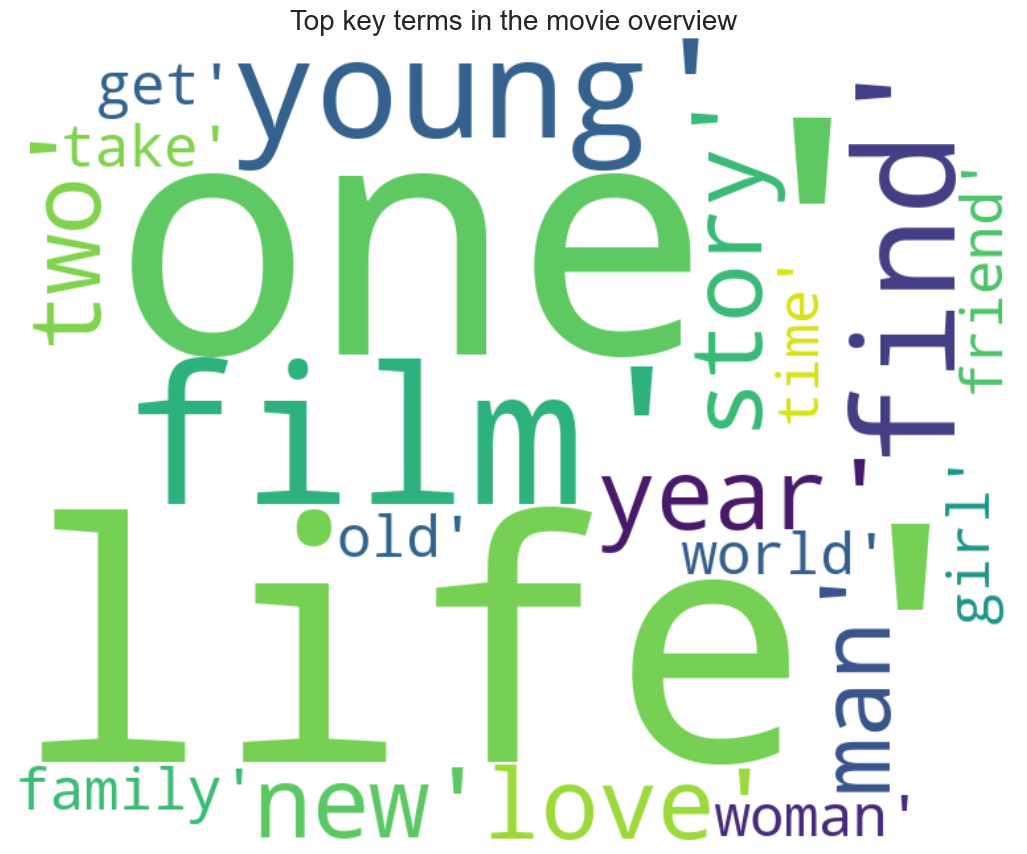

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = df_voc.sort_values(ascending=False, by ='count')[:20].text.values
plt.rcParams['figure.figsize'] = (13, 13)

#assigning shape to the word cloud
mask = np.array(Image.open('C:\\Users\\Youe\\Downloads\\archive\\Awards\\trophy.png'))
wordcloud = WordCloud(max_words=1000000,background_color="white",mask=mask).generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Top key terms in the movie overview')
plt.show()

Text-based features can be used to find items (movies) that are similar in content. For instance, recommending movies based on the similarity of their plot summaries or suggesting articles with similar topics.

# Clustering

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
bow_transformer = CountVectorizer(analyzer = text_cleanser).fit(df_desc['overview'])
desc_bow = bow_transformer.transform(df_desc['overview'])
print('Shape of the generated matrix : ',desc_bow.shape)
sparsity = desc_bow.nnz/(desc_bow.shape[0]*desc_bow.shape[1])*100.0
print('Sparsity of the generated matrix',round(sparsity,4))

Shape of the generated matrix :  (44397, 68598)
Sparsity of the generated matrix 0.042


In [17]:
import ast

In [18]:
def process_genres(genres_str):
    if pd.isna(genres_str):
        return []
    else:
        try:
            genres_list = ast.literal_eval(genres_str)
            return [genre['name'].strip().replace(" ", "_") for genre in genres_list]
        except (SyntaxError, ValueError):
            return []

movie['genres'] = movie['genres'].apply(process_genres)

In [19]:
movie.head()

,genres,movieId,original_language,overview,release_date,title,vote_average,vote_count
0,"[Animation, Comedy, Family]",862,en,Led by Woody Andy s toys live happily in his ...,1995-10-30,Toy Story,7.7,5415.0
1,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,1995-12-15,Jumanji,6.9,2413.0
2,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,1995-12-22,Grumpier Old Men,6.5,92.0
3,"[Comedy, Drama, Romance]",31357,en,Cheated on mistreated and stepped on the wom...,1995-12-22,Waiting to Exhale,6.1,34.0
4,[Comedy],11862,en,Just when George Banks has recovered from his ...,1995-02-10,Father of the Bride Part II,5.7,173.0


In [76]:
#my_list = movie['genres'] 
#result_string = ', '.join(str(item) for item in my_list)

#result_string = ', '.join(map(str, my_list))
#movie['all_feature'] = result_string 


In [20]:
movies_genres = movie.genres  # List of genre lists for each movie

vector = TfidfVectorizer(
    max_df=1.0,
    min_df=1,
    strip_accents='ascii',
    stop_words='english',
    lowercase=True,
    use_idf=True,
    norm=u'l2',
    smooth_idf=True
)

tfidf = vector.fit_transform([' '.join(genres) for genres in movies_genres])
print(movies_genres)


0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
44392        [Drama, Action, Romance]
44393                         [Drama]
44394       [Action, Drama, Thriller]
44395                              []
44396                              []
Name: genres, Length: 44397, dtype: object


In [28]:
from sklearn.cluster import MiniBatchKMeans


k = 500
kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++')
kmeans.fit(tfidf)  

# Create an empty list to store cluster labels for all movies
cluster_labels = []

# Iterate through all movies and assign cluster labels
for movie_index in range(len(movies_genres)):
    movie_genres_list = movies_genres.iloc[movie_index]
    movie_tfidf = vector.transform([' '.join(movie_genres_list)])
    cluster_label = kmeans.predict(movie_tfidf)[0]  # Extract the label from the array
    cluster_labels.append(cluster_label)

# Assign the cluster labels to the 'cluster' column in the 'movie' DataFrame
movie['cluster'] = cluster_labels

c:\Users\Youe\Downloads\Year3 ITC\TP-Intro DS\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



MiniBatchKMeans(n_clusters=500)

Using the scikit-learn library in Python for clustering movie descriptions based on their TF-IDF (Term Frequency-Inverse Document Frequency) features

In [29]:
from sklearn.metrics.pairwise import linear_kernel
def find_similar_movies(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n] 

In [30]:
for ind in find_similar_movies(tfidf,600,8):
    print(movie.loc[ind].title)

Space Adventure Cobra
Flatland
Cencoroll
The Animatrix
Pale Cocoon
Trava: Fist Planet
Sin: The Movie
Invaders from the Deep
